In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import *

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.utils import shuffle
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB3
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [ ]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

class main_class():
    def __init__(self, train_folder_path, test_folder_path):
        self.train_folder_path = train_folder_path
        self.test_folder_path = test_folder_path

    def data_frame(self, folder_path):
        path_add = Path(folder_path)
        images_link = list(path_add.glob(r'**/*.*'))
        images_name = [x.parts[-2] for x in images_link]
        images_labels = preprocessing.LabelEncoder().fit_transform(images_name)

        df = pd.DataFrame(list(zip(images_link, images_name, images_labels)), columns=['Link', 'Name', 'label'])
        return df

    def EfficientNet_call(self, EfficientNet, imsize, epoch, batch):
        train_df = self.data_frame(self.train_folder_path)
        test_df = self.data_frame(self.test_folder_path)

        # Load and preprocess train data
        x_train, y_train = [], []
        for i in train_df.Link:
            img_pre = cv2.imread(str(i))
            img_pre = cv2.resize(img_pre, (imsize, imsize))
            x_train.append(img_pre)
            y_train.append(train_df.loc[train_df['Link'] == i].label.values[0])
        x_train = np.array(x_train)
        y_train = to_categorical(y_train)

        # Load and preprocess test data
        x_test, y_test = [], []
        for i in test_df.Link:
            img_pre = cv2.imread(str(i))
            img_pre = cv2.resize(img_pre, (imsize, imsize))
            x_test.append(img_pre)
            y_test.append(test_df.loc[test_df['Link'] == i].label.values[0])
        x_test = np.array(x_test)
        y_test = to_categorical(y_test)

        efficient = EfficientNet(weights='imagenet', include_top=False, input_shape=(imsize, imsize, 3))

        model = efficient.output
        model = tf.keras.layers.GlobalAveragePooling2D()(model)
        model = tf.keras.layers.Dropout(0.5)(model)
        model = tf.keras.layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='softmax')(model)
        model = tf.keras.models.Model(inputs=efficient.input, outputs=model)
        model.compile(loss='squared_hinge',
                      optimizer="adam",
                      metrics=["accuracy"])
        model.summary()

        tensorboard = TensorBoard(log_dir="logs")
        checkpoint = ModelCheckpoint("efficient.h5",
                                     monitor='val_accuracy',
                                     mode="auto",
                                     verbose=1,
                                     save_best_only=True)
        reduce_LR = ReduceLROnPlateau(monitor="val_accuracy",
                                      factor=0.3,
                                      patience=2,
                                      min_delta=0.001,
                                      mode="auto",
                                      verbose=1)
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        history = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            epochs=epoch,
                            verbose=1,
                            batch_size=batch,
                            callbacks=[tensorboard, checkpoint, reduce_LR, es])

        return model, history


    def generate_classification_report(self, y_true, y_pred, target_names):

      report = classification_report(y_true, y_pred, target_names=target_names)
      print(report)

    def generate_confusion_matrix(self, y_true, y_pred, target_names):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()


# Example usage
train_folder_path = "/content/Dataset/train"
test_folder_path = "/content/Dataset/test"
main_instance = main_class(train_folder_path, test_folder_path)

# Assuming EfficientNet, imsize, epoch, and batch are defined
model, history = main_instance.EfficientNet_call(EfficientNetB3, 224, 20, 32)

# Assuming y_true and y_pred are the true labels and predictions, and target_names is the list of class names
y_true = np.argmax(y_test, axis=1)  # Replace with your true labels
y_pred = np.argmax(model.predict(x_test), axis=1)  # Replace with your predicted labels
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']  # Replace with your own class names
main_instance.generate_classification_report(y_true, y_pred, target_names)
main_instance.generate_confusion_matrix(y_true, y_pred, target_names)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 122s 594ms/step - loss: 1.1571 - accuracy: 0.6245 - val_loss: 1.2127 - val_accuracy: 0.5706 - lr: 0.0010
Epoch 2/20
95/95 [==============================] - ETA: 0s - loss: 1.0789 - accuracy: 0.6879
Epoch 2: val_accuracy improved from 0.57060 to 0.64877, saving model to efficient.h5
95/95 [==============================] - 51s 534ms/step - loss: 1.0789 - accuracy: 0.6879 - val_loss: 1.1153 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 3/20
95/95 [==============================] - ETA: 0s - loss: 1.0174 - accuracy: 0.7410
Epoch 3: val_accuracy improved from 0.64877 to 0.67561, saving model to efficient.h5
95/95 [==============================] - 53s 558ms/step - loss: 1.0174 - accuracy: 0.7410 - val_loss: 1.0754 - val_accuracy: 0.6756 - lr: 0.0010
Epoch 4/20
95/95 [==============================] - ETA: 0s - loss: 0.9886 - accuracy: 0.7663
Epoch 4: val_accuracy did not improve from 0.67561
95/95 [==============================] - 52s 546ms/step - los

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/NOT_DATA.zip /content/

In [ ]:
!unzip /content/drive/MyDrive/NOT_DATA.zip

Archive:  /content/drive/MyDrive/NOT_DATA.zip
   creating: NOT_DATA/
   creating: NOT_DATA/test/
   creating: NOT_DATA/test/Acne/
  inflating: NOT_DATA/test/Acne/07PerioralDermEye.jpg  
  inflating: NOT_DATA/test/Acne/07Rhinophyma1.jpg  
  inflating: NOT_DATA/test/Acne/07rhnophymas0321051.jpg  
  inflating: NOT_DATA/test/Acne/07RosaceaFulFAce.jpg  
  inflating: NOT_DATA/test/Acne/07RosaceaMilia0120.jpg  
  inflating: NOT_DATA/test/Acne/07RosaceaOK0828063.jpg  
  inflating: NOT_DATA/test/Acne/07sebDerem1101051.jpg  
  inflating: NOT_DATA/test/Acne/07SteroidPerioral.jpg  
  inflating: NOT_DATA/test/Acne/07SteroidPerioral1.jpg  
  inflating: NOT_DATA/test/Acne/07VascularFace0120.jpg  
  inflating: NOT_DATA/test/Acne/08PerioralDerm1.jpg  
  inflating: NOT_DATA/test/Acne/acne-closed-comedo-003.jpg  
  inflating: NOT_DATA/test/Acne/acne-closed-comedo-1.jpg  
  inflating: NOT_DATA/test/Acne/acne-closed-comedo-13.jpg  
  inflating: NOT_DATA/test/Acne/acne-closed-comedo-15.jpg  
  inflating: NO

In [ ]:
!cp -r  /content/NOT_DATA/test /content/Dataset/test/
!cp -r  /content/NOT_DATA/train /content/Dataset/train/

In [ ]:
from pathlib import Path

In [ ]:
dataset_path = Path("/content/", "Dataset")
data_info=main_class(dataset_path)
df=data_info.data_frame()

TypeError: ignored

In [ ]:
print(df)

                                                   Link    Name  label
0     /content/Dataset/train/Eczema/eczema-asteatoti...  Eczema      3
1     /content/Dataset/train/Eczema/eczema-nummular-...  Eczema      3
2     /content/Dataset/train/Eczema/eczema-fingertip...  Eczema      3
3     /content/Dataset/train/Eczema/03DermatitisLids...  Eczema      3
4      /content/Dataset/train/Eczema/eczema-foot-78.jpg  Eczema      3
...                                                 ...     ...    ...
3864  /content/Dataset/test/Acne/hidradenitis-suppur...    Acne      0
3865         /content/Dataset/test/Acne/rosacea-107.jpg    Acne      0
3866   /content/Dataset/test/Acne/acne-excoriated-2.jpg    Acne      0
3867   /content/Dataset/test/Acne/acne-infantile-10.jpg    Acne      0
3868          /content/Dataset/test/Acne/rosacea-38.jpg    Acne      0

[3869 rows x 3 columns]


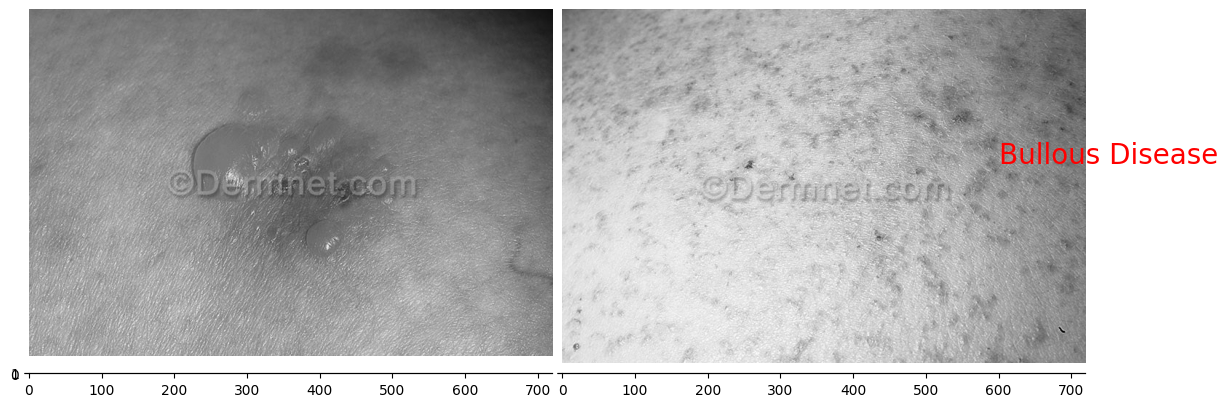

In [ ]:
from PIL import Image
name_image=np.random.choice(np.unique(df.Name))
data_info.img_show(df[df.Name==name_image],2)

In [ ]:
main_dt=data_info.EfficientNet_call(df,EfficientNetB3,224,20,32)


43941136/43941136 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


109/109 [==============================] - 134s 552ms/step - loss: 1.1608 - accuracy: 0.6258 - val_loss: 1.1401 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 2/20
109/109 [==============================] - ETA: 0s - loss: 1.0463 - accuracy: 0.7148
Epoch 2: val_accuracy improved from 0.62532 to 0.71318, saving model to efficient.h5
109/109 [==============================] - 58s 535ms/step - loss: 1.0463 - accuracy: 0.7148 - val_loss: 1.0408 - val_accuracy: 0.7132 - lr: 0.0010
Epoch 3/20
109/109 [==============================] - ETA: 0s - loss: 0.9964 - accuracy: 0.7579
Epoch 3: val_accuracy did not improve from 0.71318
109/109 [==============================] - 55s 506ms/step - loss: 0.9964 - accuracy: 0.7579 - val_loss: 1.1102 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 4/20
109/109 [==============================] - ETA: 0s - loss: 0.9730 - accuracy: 0.7754
Epoch 4: val_accuracy did not improve from 0.71318

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
109/10

In [ ]:
# Rest of the main_class and other methods

def generate_classification_report(y_true, y_pred, target_names):
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(report)

# Example usage
train_folder_path = "/content/Dataset/train"
test_folder_path = "/content/Dataset/test"
main_instance = main_class(train_folder_path, test_folder_path)

# Assuming EfficientNet, imsize, epoch, and batch are defined
model, history = main_instance.EfficientNet_call(EfficientNetB3, 224, 20, 32)

# Assuming y_true and y_pred are the true labels and predictions, and target_names is the list of class names
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)
target_names = ['Acne', 'Atopic Dermatitis','Bullous Disease', 'Eczema']  # Replace with your own class names
generate_classification_report(y_true, y_pred, target_names)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_2[0][0]'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 117s 577ms/step - loss: 1.1679 - accuracy: 0.6092 - val_loss: 1.1884 - val_accuracy: 0.5683 - lr: 0.0010
Epoch 2/20
95/95 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.7118
Epoch 2: val_accuracy improved from 0.56826 to 0.64877, saving model to efficient.h5
95/95 [==============================] - 53s 558ms/step - loss: 1.0499 - accuracy: 0.7118 - val_loss: 1.1009 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 3/20
95/95 [==============================] - ETA: 0s - loss: 1.0117 - accuracy: 0.7457
Epoch 3: val_accuracy improved from 0.64877 to 0.71412, saving model to efficient.h5
95/95 [==============================] - 53s 560ms/step - loss: 1.0117 - accuracy: 0.7457 - val_loss: 1.0416 - val_accuracy: 0.7141 - lr: 0.0010
Epoch 4/20
95/95 [==============================] - ETA: 0s - loss: 0.9845 - accuracy: 0.7676
Epoch 4: val_accuracy did not improve from 0.71412
95/95 [==============================] - 52s 547ms/step - los

NameError: ignored

In [ ]:
result_pre = np.argmax(main_dt[0].predict(main_dt[2]), axis=1)
result_acc = np.argmax(main_dt[4], axis=1)
plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(main_dt[2][i])
    plt.title('Acne' if result_pre[i]==0
                else 'Atopic Dermatitis' if result_pre[i]==1
                else 'Bullous Disease' if result_pre[i]==2
                else 'Eczema',fontsize=20)
    plt.suptitle('Test Image plot and labels',fontsize=30)
    plt.axis("off")

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import classification_report

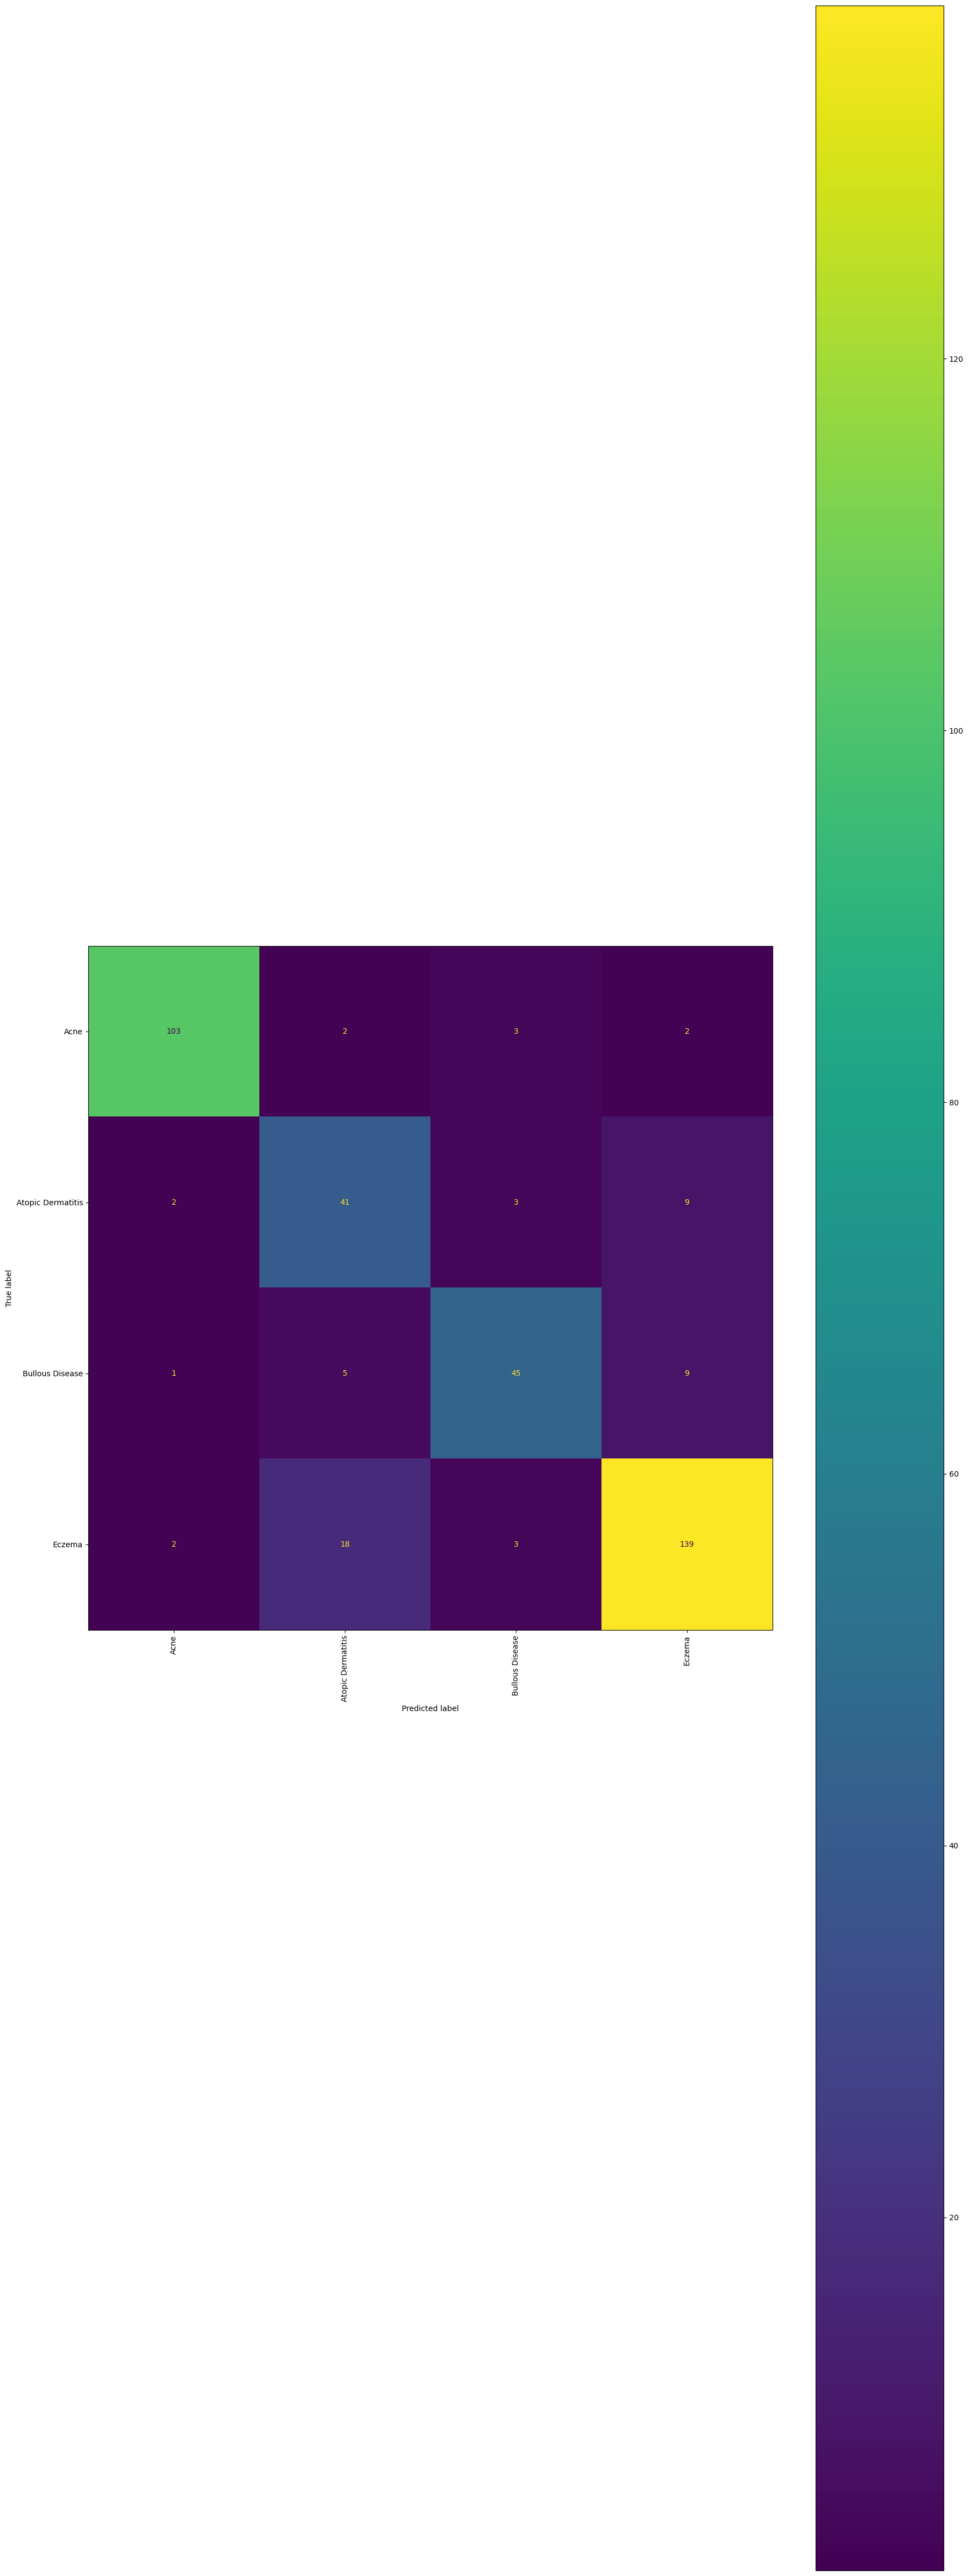

In [ ]:
con_max = confusion_matrix(result_acc,result_pre)
cm = confusion_matrix(result_acc,result_pre)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['Acne', 'Atopic Dermatitis','Bullous Disease', 'Eczema'])
fig, ax = plt.subplots(figsize=(20,120))
cmp.plot(ax=ax, xticks_rotation=90)

In [ ]:
y_true = np.argmax(main_instance.y_test, axis=1)  # Replace with your true labels
y_pred = np.argmax(model.predict(main_instance.x_test), axis=1)  # Replace with your predicted labels
target_names = ['Acne', 'Atopic Dermatitis', 'Bullous Disease', 'Eczema']  # Replace with your own class names
main_instance.generate_classification_report(y_true, y_pred, target_names)
main_instance.generate_confusion_matrix(y_true, y_pred, target_names)

NameError: ignored

In [ ]:
df_acc=pd.DataFrame()
df_acc['Loss']=main_dt[5].history['loss']
df_acc['Value Loss']=main_dt[5].history['val_loss']
df_acc['Accuracy']=main_dt[5].history['accuracy']
df_acc['Value Accuracy']=main_dt[5].history['val_accuracy']
df_acc

,Loss,Value Loss,Accuracy,Value Accuracy
0,1.160823,1.140144,0.625790,0.625323
1,1.046340,1.040780,0.714819,0.713178
2,0.996408,1.110191,0.757898,0.614987
3,0.972988,1.080773,0.775416,0.658915
4,0.897647,0.954485,0.857553,0.795866
5,0.866465,0.935994,0.892878,0.813953
6,0.851445,0.917617,0.902929,0.842377
7,0.832335,0.916717,0.926192,0.829457
8,0.824897,0.928700,0.932510,0.829457
9,0.805986,0.908445,0.953188,0.842377


<Axes: >

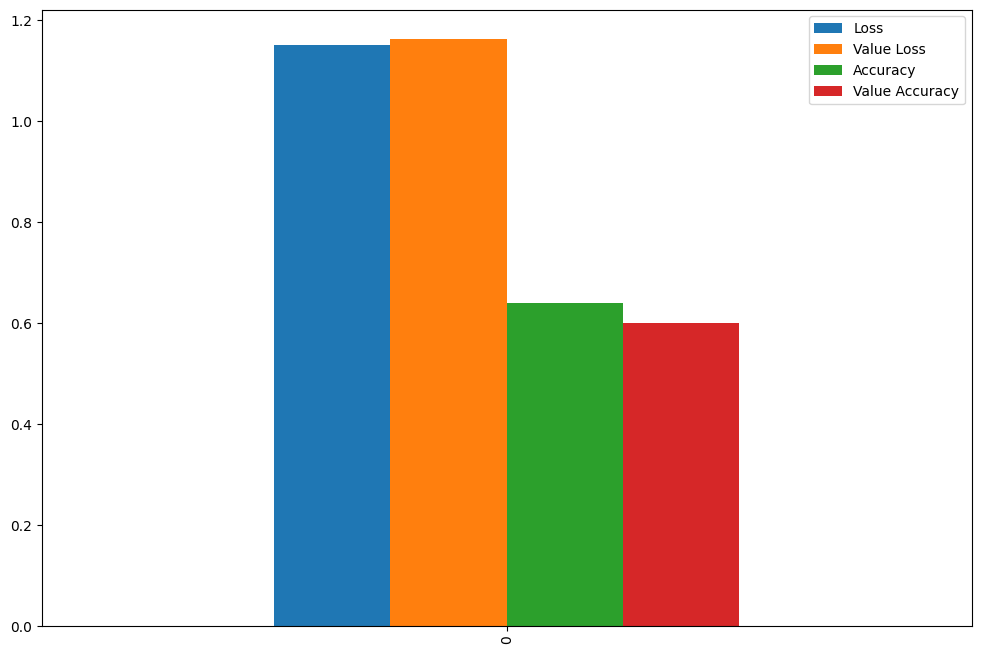

In [ ]:
df_acc.sort_values('Loss',ascending=False).head(1).plot(kind='bar',figsize = (12,8))

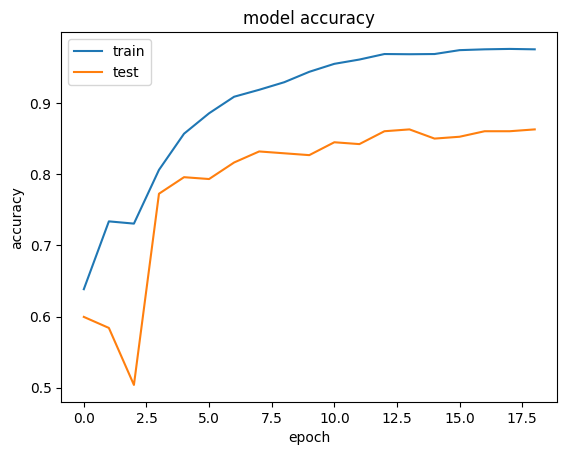

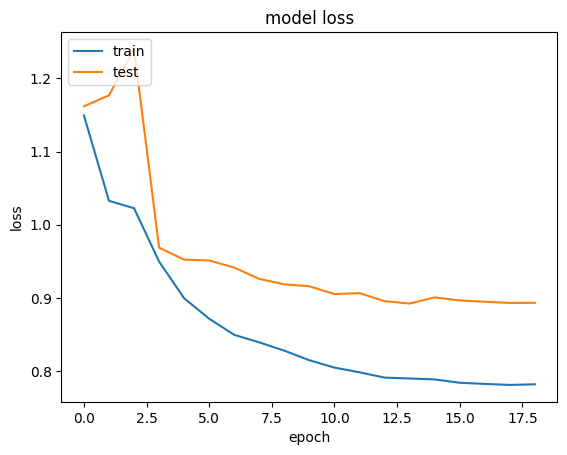

In [ ]:
# summarize history for accuracy
plt.plot(main_dt[5].history['accuracy'])
plt.plot(main_dt[5].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(main_dt[5].history['loss'])
plt.plot(main_dt[5].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# class main_class():
#     def __init__(self,path_add):
#         self.path_add=path_add

#     def data_frame(self):
#         images_link = list(self.path_add.glob(r'**/*.*'))
#         images_name = [x.parents[0].stem for x in images_link]
#         images_labels=preprocessing.LabelEncoder().fit_transform(images_name)

#         df=pd.DataFrame(list(zip(images_link,images_name,images_labels)),columns=['Link','Name','label'])
#         return df

#     def img_show(self,image_links,plot_size,):
#         df=image_links.sample(frac=1)
#         fig = plt.figure(1, figsize=(30, 30))
#         grid = ImageGrid(fig,121, nrows_ncols=(plot_size, 2), axes_pad=0.10)
#         i = 0
#         for category_id, category in enumerate(df.Name.unique()):
#             for filepath in df[df['Name'] == category]['Link'].values[:2]:
#                 ax = grid[i]
#                 #img = image.load_img(filepath,(150,150))
#                 #img=image.img_to_array(img)
#                 #ax.imshow(img/255)


#                 image = Image.open(filepath).convert("L")
#                 arr = np.asarray(image)
#                 ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
#                 ax.axis('off')

#                 if i % 2 == 2 - 1:
#                     ax.text(600, 200, category, verticalalignment='center',fontsize=20,color = 'red')


#                 i+=1

#         plt.show()

#     def EfficientNet_call(self,df,EfficientNet,imsize,epoch,batch):
#         image_data=[]
#         for i in df.Link:
#             img_pre=cv2.imread(str(i))
#             img_pre=cv2.resize(img_pre, (imsize,imsize))
#             image_data.append(img_pre)

#         x=np.array(image_data)
#         y=to_categorical(df.label)
#         x_data, y_data=shuffle(x,y,random_state=42)
#         xtrain,xtest,ytrain,ytest=model_selection.train_test_split(x_data, y_data, test_size=0.1, random_state=42)

#         efficient = EfficientNet(weights='imagenet',include_top = False, input_shape=(imsize, imsize, 3))

#         model = efficient.output
#         model = tf.keras.layers.GlobalAveragePooling2D()(model)
#         model = tf.keras.layers.Dropout(0.5)(model)
#         model = tf.keras.layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
#              ='softmax')(model)
#         model = tf.keras.models.Model(inputs = efficient.input , outputs = model)
#         model.compile(loss = 'squared_hinge',
#                       optimizer = "adam",
#                       metrics=["accuracy"]
#                       )
#         model.summary()



#         tensorboard = TensorBoard(log_dir="logs")
#         checkpoint = ModelCheckpoint("efficient.h5",
#                                      monitor='val_accuracy',
#                                      mode = "auto",
#                                      verbose = 1,
#                                      save_best_only =True)
#         reduce_LR = ReduceLROnPlateau(monitor="val_accuracy",
#                                       factor = 0.3,
#                                       patience = 2,
#                                       min_delta=0.001,
#                                       mode = "auto",
#                                       verbose = 1)
#         es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#         history = model.fit(xtrain, ytrain,
#                   validation_data =(xtest,ytest),
#                   epochs = epoch,
#                   verbose =1,
#                   batch_size = batch,
#                   callbacks = [tensorboard, checkpoint, reduce_LR,es])

#         return model,xtrain,xtest,ytrain,ytest,history


In [ ]:
# import numpy as np
# import pandas as pd
# import cv2
# from pathlib import Path
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import matplotlib.pyplot as plt

# class main_class():
#     def __init__(self, train_folder_path, test_folder_path):
#         self.train_folder_path = train_folder_path
#         self.test_folder_path = test_folder_path

#     def data_frame(self, folder_path):
#         path_add = Path(folder_path)
#         images_link = list(path_add.glob(r'**/*.*'))
#         images_name = [x.parts[-2] for x in images_link]
#         images_labels = preprocessing.LabelEncoder().fit_transform(images_name)

#         df = pd.DataFrame(list(zip(images_link, images_name, images_labels)), columns=['Link', 'Name', 'label'])
#         return df

#     def EfficientNet_call(self, EfficientNet, imsize, epoch, batch):
#         train_df = self.data_frame(self.train_folder_path)
#         test_df = self.data_frame(self.test_folder_path)

#         # Load and preprocess train data
#         x_train, y_train = [], []
#         for i in train_df.Link:
#             img_pre = cv2.imread(str(i))
#             img_pre = cv2.resize(img_pre, (imsize, imsize))
#             x_train.append(img_pre)
#             y_train.append(train_df.loc[train_df['Link'] == i].label.values[0])
#         x_train = np.array(x_train)
#         y_train = to_categorical(y_train)

#         # Load and preprocess test data
#         x_test, y_test = [], []
#         for i in test_df.Link:
#             img_pre = cv2.imread(str(i))
#             img_pre = cv2.resize(img_pre, (imsize, imsize))
#             x_test.append(img_pre)
#             y_test.append(test_df.loc[test_df['Link'] == i].label.values[0])
#         x_test = np.array(x_test)
#         y_test = to_categorical(y_test)

#         efficient = EfficientNet(weights='imagenet', include_top=False, input_shape=(imsize, imsize, 3))

#         model = efficient.output
#         model = tf.keras.layers.GlobalAveragePooling2D()(model)
#         model = tf.keras.layers.Dropout(0.5)(model)
#         model = tf.keras.layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='softmax')(model)
#         model = tf.keras.models.Model(inputs=efficient.input, outputs=model)
#         model.compile(loss='squared_hinge',
#                       optimizer="adam",
#                       metrics=["accuracy"])
#         model.summary()

#         tensorboard = TensorBoard(log_dir="logs")
#         checkpoint = ModelCheckpoint("efficient.h5",
#                                      monitor='val_accuracy',
#                                      mode="auto",
#                                      verbose=1,
#                                      save_best_only=True)
#         reduce_LR = ReduceLROnPlateau(monitor="val_accuracy",
#                                       factor=0.3,
#                                       patience=2,
#                                       min_delta=0.001,
#                                       mode="auto",
#                                       verbose=1)
#         es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#         history = model.fit(x_train, y_train,
#                             validation_data=(x_test, y_test),
#                             epochs=epoch,
#                             verbose=1,
#                             batch_size=batch,
#                             callbacks=[tensorboard, checkpoint, reduce_LR, es])

#         return model, history

#     def generate_classification_report(self, y_true, y_pred, target_names):
#         report = classification_report(y_true, y_pred, target_names=target_names)
#         print(report)

#     def generate_confusion_matrix(self, y_true, y_pred, target_names):
#         cm = confusion_matrix(y_true, y_pred)
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
#         plt.xlabel('Predicted labels')
#         plt.ylabel('True labels')
#         plt.title('Confusion Matrix')
#         plt.show()


# # Example usage
# train_folder_path = "/content/Dataset/train"
# test_folder_path = "/content/Dataset/test"
# main_instance = main_class(train_folder_path, test_folder_path)

# # Assuming EfficientNet, imsize, epoch, and batch are defined
# model, history = main_instance.EfficientNet_call(EfficientNetB3, 224, 20, 32)

# y_true = np.argmax(main_instance.y_test, axis=1)  # Replace with your true labels
# y_pred = np.argmax(model.predict(main_instance.x_test), axis=1)  # Replace with your predicted labels
# target_names = ['Acne', 'Atopic Dermatitis', 'Bullous Disease', 'Eczema']  # Replace with your own class names
# main_instance.generate_classification_report(y_true, y_pred, target_names)
# main_instance.generate_confusion_matrix(y_true, y_pred, target_names)


In [ ]:
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are the true labels and predictions, and target_names is the list of class names
y_true = np.argmax(main_instance.y_test, axis=1)  # Replace with your true labels
y_pred = np.argmax(model.predict(main_instance.x_test), axis=1)  # Replace with your predicted labels
target_names = ['Acne', 'Atopic Dermatitis', 'Bullous Disease', 'Eczema']  # Replace with your own class names

print(classification_report(y_true, y_pred, target_names=target_names))


AttributeError: ignored

43941136/43941136 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_2 (Rescaling)     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


95/95 [==============================] - 131s 576ms/step - loss: 1.1580 - accuracy: 0.6262 - val_loss: 1.1168 - val_accuracy: 0.6628 - lr: 0.0010
Epoch 2/20
95/95 [==============================] - ETA: 0s - loss: 1.0672 - accuracy: 0.6972
Epoch 2: val_accuracy did not improve from 0.66278
95/95 [==============================] - 49s 513ms/step - loss: 1.0672 - accuracy: 0.6972 - val_loss: 1.2619 - val_accuracy: 0.4854 - lr: 0.0010
Epoch 3/20
95/95 [==============================] - ETA: 0s - loss: 1.0237 - accuracy: 0.7314
Epoch 3: val_accuracy improved from 0.66278 to 0.70128, saving model to efficient.h5
95/95 [==============================] - 52s 550ms/step - loss: 1.0237 - accuracy: 0.7314 - val_loss: 1.0502 - val_accuracy: 0.7013 - lr: 0.0010
Epoch 4/20
95/95 [==============================] - ETA: 0s - loss: 0.9706 - accuracy: 0.7859
Epoch 4: val_accuracy did not improve from 0.70128
95/95 [==============================] - 51s 539ms/step - loss: 0.9706 - accuracy: 0.7859 - val

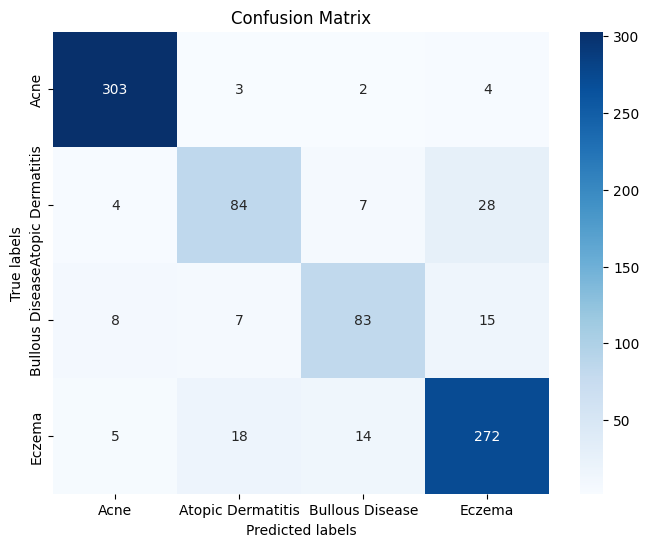

TypeError: ignored

In [ ]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class main_class():
    def __init__(self, train_folder_path, test_folder_path):
        self.train_folder_path = train_folder_path
        self.test_folder_path = test_folder_path

    def data_frame(self, folder_path):
        path_add = Path(folder_path)
        images_link = list(path_add.glob(r'**/*.*'))
        images_name = [x.parts[-2] for x in images_link]
        images_labels = preprocessing.LabelEncoder().fit_transform(images_name)

        df = pd.DataFrame(list(zip(images_link, images_name, images_labels)), columns=['Link', 'Name', 'label'])
        return df

    def EfficientNet_call(self, EfficientNet, imsize, epoch, batch):
        train_df = self.data_frame(self.train_folder_path)
        test_df = self.data_frame(self.test_folder_path)

        # Load and preprocess train data
        x_train, y_train = [], []
        for i in train_df.Link:
            img_pre = cv2.imread(str(i))
            img_pre = cv2.resize(img_pre, (imsize, imsize))
            x_train.append(img_pre)
            y_train.append(train_df.loc[train_df['Link'] == i].label.values[0])
        x_train = np.array(x_train)
        y_train = to_categorical(y_train)

        # Load and preprocess test data
        x_test, y_test = [], []
        for i in test_df.Link:
            img_pre = cv2.imread(str(i))
            img_pre = cv2.resize(img_pre, (imsize, imsize))
            x_test.append(img_pre)
            y_test.append(test_df.loc[test_df['Link'] == i].label.values[0])
        x_test = np.array(x_test)
        y_test = to_categorical(y_test)

        efficient = EfficientNet(weights='imagenet', include_top=False, input_shape=(imsize, imsize, 3))

        model = efficient.output
        model = tf.keras.layers.GlobalAveragePooling2D()(model)
        model = tf.keras.layers.Dropout(0.5)(model)
        model = tf.keras.layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='softmax')(model)
        model = tf.keras.models.Model(inputs=efficient.input, outputs=model)
        model.compile(loss='squared_hinge', optimizer="adam", metrics=["accuracy"])
        model.summary()

        tensorboard = TensorBoard(log_dir="logs")
        checkpoint = ModelCheckpoint("efficient.h5", monitor='val_accuracy', mode="auto", verbose=1, save_best_only=True)
        reduce_LR = ReduceLROnPlateau(monitor="val_accuracy", factor=0.3, patience=2, min_delta=0.001, mode="auto", verbose=1)
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epoch, verbose=1, batch_size=batch, callbacks=[tensorboard, checkpoint, reduce_LR, es])

        y_true = np.argmax(y_test, axis=1)  # Replace with your true labels
        y_pred = np.argmax(model.predict(x_test), axis=1)  # Replace with your predicted labels
        target_names = ['Acne', 'Atopic Dermatitis', 'Bullous Disease', 'Eczema']  # Replace with your own class names
        self.generate_classification_report(y_true, y_pred, target_names)
        self.generate_confusion_matrix(y_true, y_pred, target_names)

    def generate_classification_report(self, y_true, y_pred, target_names):
        report = classification_report(y_true, y_pred, target_names=target_names)
        print(report)

    def generate_confusion_matrix(self, y_true, y_pred, target_names):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

# Example usage
train_folder_path = "/content/Dataset/train"
test_folder_path = "/content/Dataset/test"
main_instance = main_class(train_folder_path, test_folder_path)

# Assuming EfficientNet, imsize, epoch, and batch are defined
model, history = main_instance.EfficientNet_call(EfficientNetB3, 224, 20, 32)


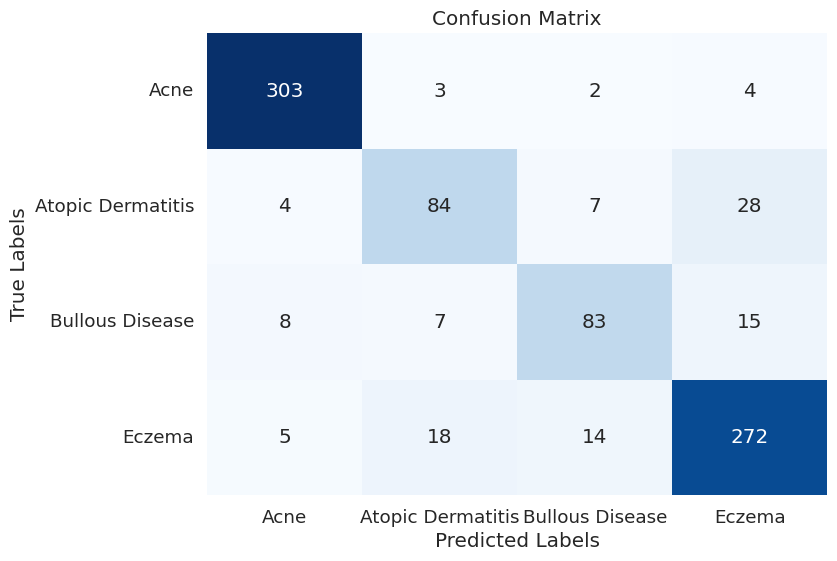

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = np.array([[303, 3, 2, 4],
                 [4, 84, 7, 28],
                 [8, 7, 83, 15],
                 [5, 18, 14, 272]])

# Define class labels
labels = ["Acne", "Atopic Dermatitis", "Bullous Disease", "Eczema"]

# Create confusion matrix plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(data, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


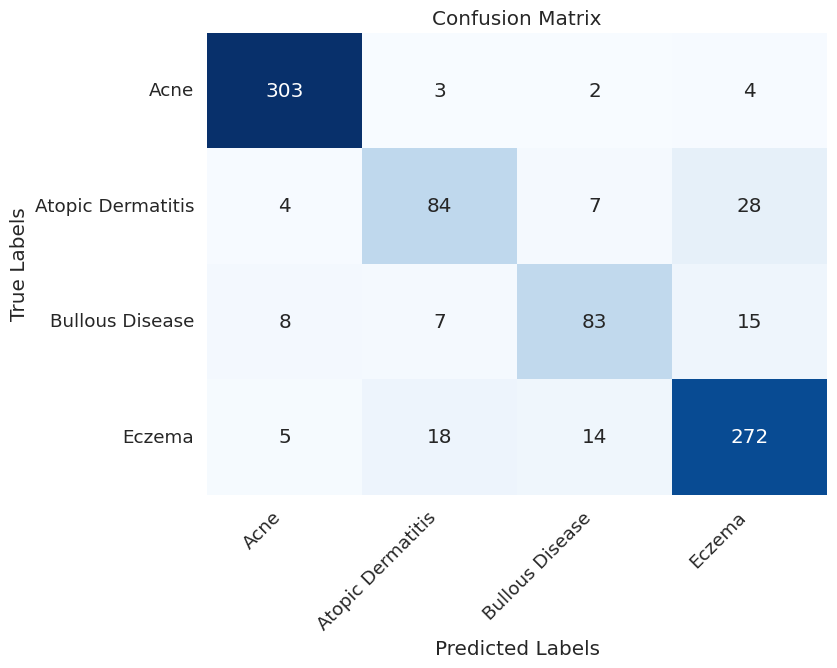

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = np.array([[303, 3, 2, 4],
                 [4, 84, 7, 28],
                 [8, 7, 83, 15],
                 [5, 18, 14, 272]])

# Define class labels
labels = ["Acne", "Atopic Dermatitis", "Bullous Disease", "Eczema"]

# Create confusion matrix plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(data, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels by 45 degrees
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


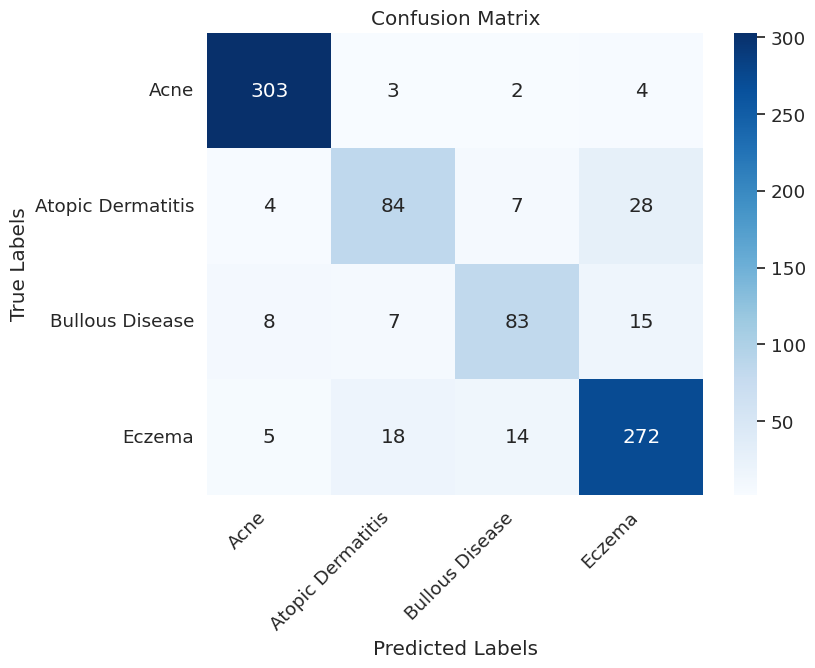

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = np.array([[303, 3, 2, 4],
                 [4, 84, 7, 28],
                 [8, 7, 83, 15],
                 [5, 18, 14, 272]])

# Define class labels
labels = ["Acne", "Atopic Dermatitis", "Bullous Disease", "Eczema"]

# Create confusion matrix plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(data, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels by 45 degrees
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
